/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01841D+00    |proj g|=  1.57934D-01

At iterate    5    f=  5.97327D+00    |proj g|=  4.46567D-02

At iterate   10    f=  5.96982D+00    |proj g|=  9.78983D-04

At iterate   15    f=  5.96982D+00    |proj g|=  3.72225D-04

At iterate   20    f=  5.96967D+00    |proj g|=  6.01169D-03

At iterate   25    f=  5.95113D+00    |proj g|=  8.31405D-02

At iterate   30    f=  5.91453D+00    |proj g|=  2.02966D-02

At iterate   35    f=  5.91400D+00    |proj g|=  6.58876D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

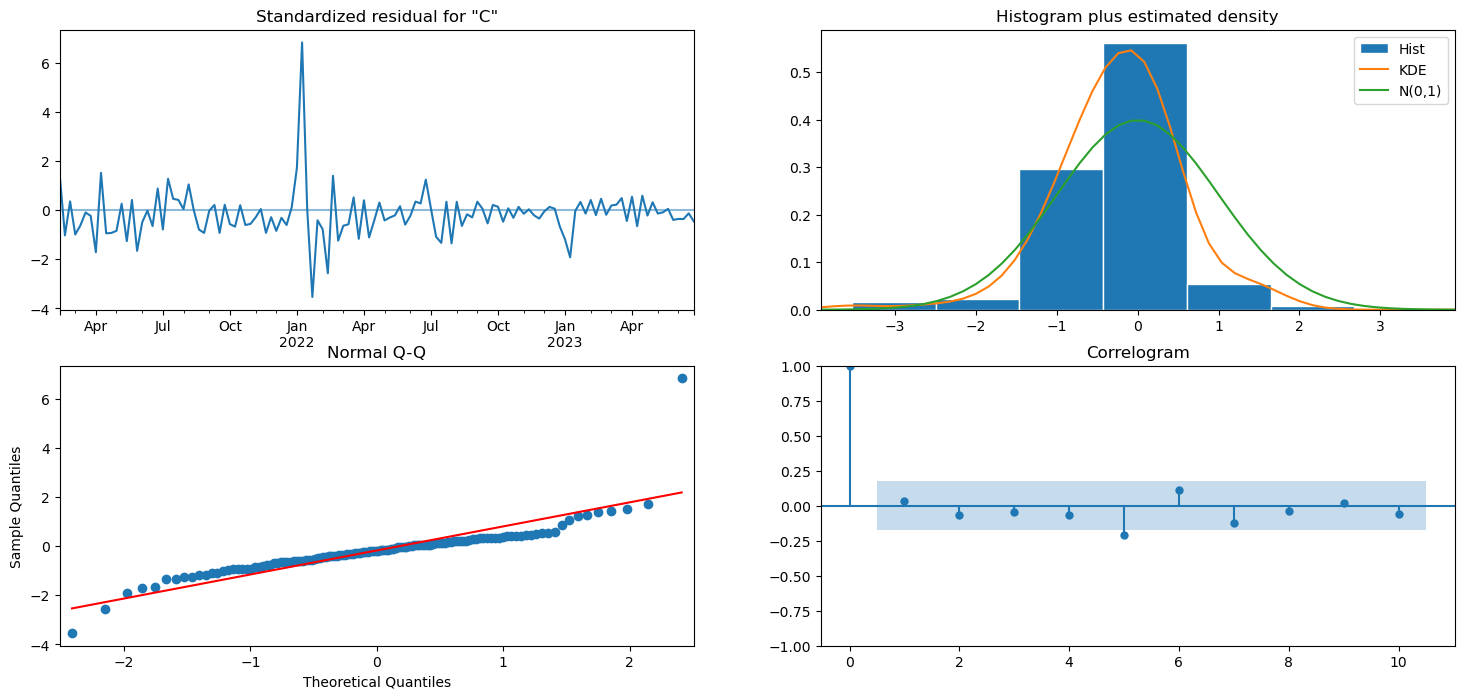

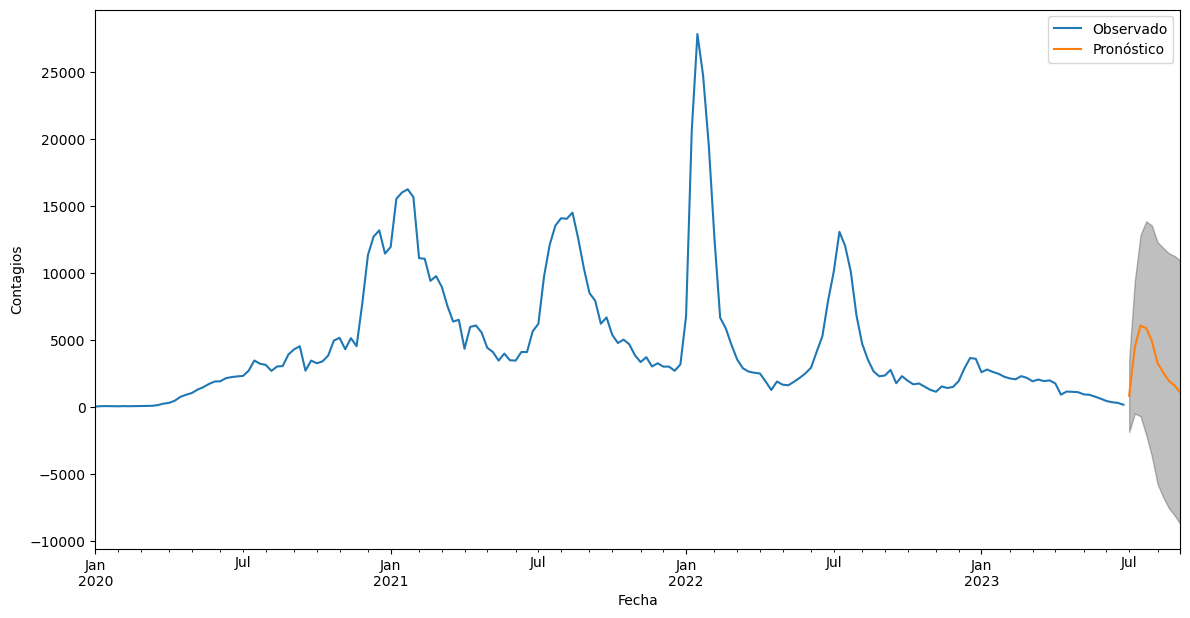

In [8]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data

# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 0  # Cambia esto por un input del usuario si necesario

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)
df_pacientesRespiratorios.head()


# Ajuste del modelo SARIMA
# Estos son solo valores de inicio basados en la discusión anterior
p = 1
d = 1
q = 4
P = 1
D = 1
Q = 1
S = 26  # asumiendo una estacionalidad semanal

model = SARIMAX(df_pacientesRespiratorios['Contagios'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Diagnósticos del modelo y resultados de resumen
print(results.summary())
results.plot_diagnostics(figsize=(18, 8))
plt.show()

# Hacer predicciones
pred_uc = results.get_forecast(steps=10)  # Pronosticar un año hacia adelante si los datos son semanales
pred_ci = pred_uc.conf_int()

# Graficar los datos observados y las predicciones
ax = df_pacientesRespiratorios['Contagios'].plot(label='Observado', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Pronóstico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Contagios')

plt.legend()
plt.show()


/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81360D+00    |proj g|=  1.05339D-01

At iterate    5    f=  1.76912D+00    |proj g|=  2.20253D-02

At iterate   10    f=  1.76493D+00    |proj g|=  4.43794D-03

At iterate   15    f=  1.76122D+00    |proj g|=  1.53494D-02

At iterate   20    f=  1.75906D+00    |proj g|=  1.13808D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     28      1     0     0   6.560D-06   1.759D+00
  F =   1.7590602787508660     

CONVERG

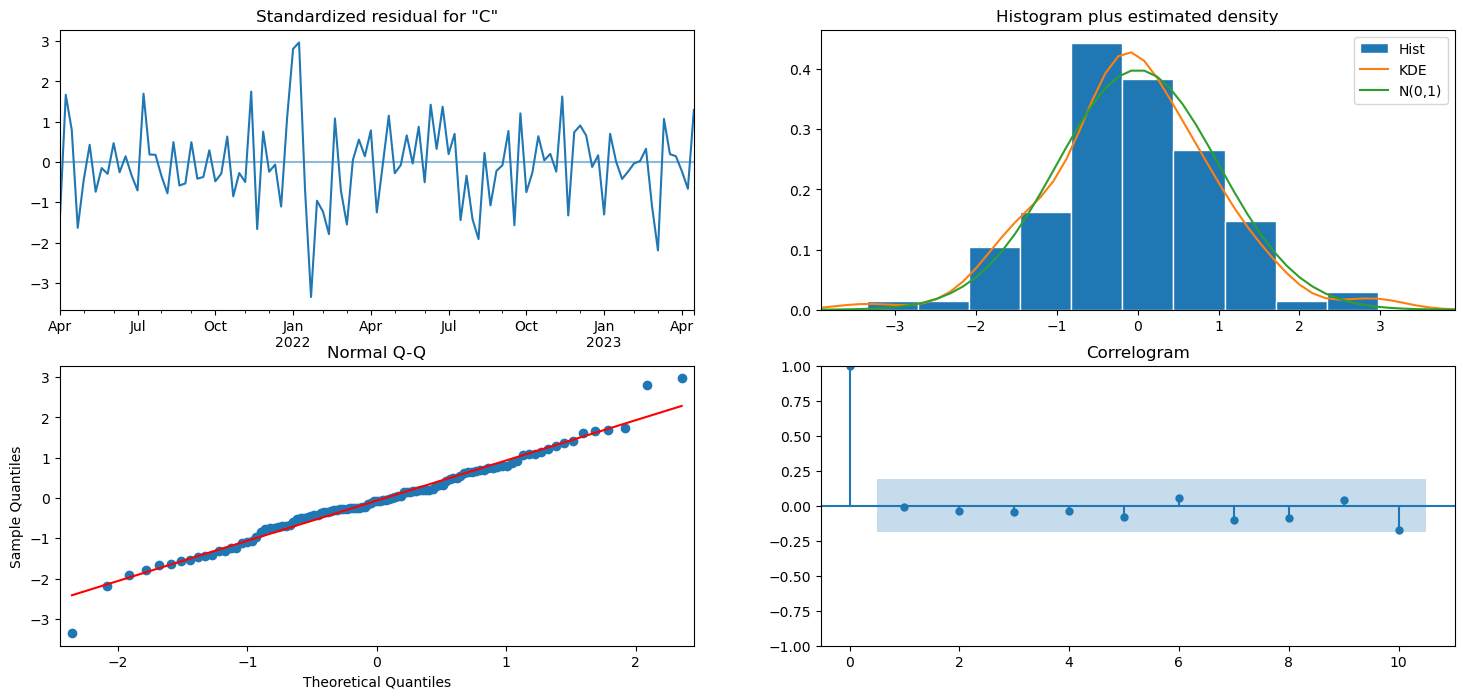

In [18]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from matplotlib import pyplot as plt
import plotly.graph_objects as go

# Suponiendo que todas las funciones anteriores y las importaciones se mantienen ...

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)

# Asegurarse de que no hay valores no positivos antes de la transformación Box-Cox
df_pacientesRespiratorios['Contagios'] = df_pacientesRespiratorios['Contagios'].clip(lower=1)

# Aplicar transformación Box-Cox
df_pacientesRespiratorios['Contagios_transformed'], lambda_ = boxcox(df_pacientesRespiratorios['Contagios'])

# Dividir los datos transformados en entrenamiento y prueba
train_data_transformed = df_pacientesRespiratorios['Contagios_transformed'].iloc[:-10]
test_data = df_pacientesRespiratorios.iloc[-10:]

p = 1
d = 1
q = 3
P = 1
D = 1
Q = 1
S = 30  # asumiendo una estacionalidad semanal

# Ajuste del modelo SARIMA con los datos de entrenamiento transformados
model = SARIMAX(train_data_transformed,
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Diagnósticos del modelo y resultados de resumen
print(results.summary())
results.plot_diagnostics(figsize=(18, 8))
plt.show()

# Hacer predicciones para el conjunto de prueba y revertir la transformación Box-Cox
pred_uc = results.get_forecast(steps=10)
predicted_mean_transformed = pred_uc.predicted_mean
predicted_mean = inv_boxcox(predicted_mean_transformed, lambda_)
predicted_mean.index = test_data.index  # Asignar directamente el índice del conjunto de prueba
pred_ci_transformed = pred_uc.conf_int()
pred_ci = pd.DataFrame()
pred_ci['lower'] = inv_boxcox(pred_ci_transformed.iloc[:, 0], lambda_)
pred_ci['upper'] = inv_boxcox(pred_ci_transformed.iloc[:, 1], lambda_)



# Calcular el error absoluto
error_absoluto = abs(test_data['Contagios'] - predicted_mean)

fig = go.Figure()

# Agregar los datos observados como una serie de líneas con puntos
fig.add_trace(go.Scatter(x=df_pacientesRespiratorios.index, y=df_pacientesRespiratorios['Contagios'], mode='lines+markers', name='Observado'))

# Agregar las predicciones como otra serie de líneas con puntos
fig.add_trace(go.Scatter(x=predicted_mean.index, y=predicted_mean, mode='lines+markers', name='Pronóstico'))

# Agregar el intervalo de confianza como un área sombreada
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0], fill=None, mode='lines', line=dict(color='lightgrey'), showlegend=False))
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1], fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False))

# Agregar los datos reales de prueba como una línea discontinua con puntos
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Contagios'], mode='lines+markers', name='Real', line=dict(dash='dash')))

# Agregar el error absoluto como una nueva serie de barras
fig.add_trace(go.Bar(x=test_data.index, y=error_absoluto, name='Error Absoluto'))

# Actualizar el diseño de la gráfica para añadir títulos y etiquetas
fig.update_layout(title='Contagios Observados, Pronósticos y Error Absoluto',
                  xaxis_title='Fecha',
                  yaxis_title='Contagios',
                  legend_title='Leyenda')

# Mostrar la figura
fig.show()

In [2]:
"""import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go



def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data

# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 0

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)

# Dividir los datos en entrenamiento y prueba
train_data = df_pacientesRespiratorios.iloc[:-10]  # Todos los datos excepto los últimos 10 para entrenamiento
test_data = df_pacientesRespiratorios.iloc[-10:]   # Los últimos 10 para prueba

# Ajuste del modelo SARIMA con los datos de entrenamiento
p = d = q = P = D = Q = 1
S = 20  # asumiendo una estacionalidad semanal
model = SARIMAX(train_data['Contagios'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Hacer predicciones para el conjunto de prueba
pred_uc = results.get_forecast(steps=10)  # Pronosticar para los 10 puntos de prueba
predicted_mean = pred_uc.predicted_mean
predicted_mean.index = test_data.index  # Asignar directamente el índice del conjunto de prueba
pred_ci = pred_uc.conf_int()

# Graficar los datos observados, las predicciones y los datos reales de prueba
ax = df_pacientesRespiratorios['Contagios'].plot(label='Observado', figsize=(14, 7))
predicted_mean.plot(ax=ax, label='Pronóstico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
test_data['Contagios'].plot(ax=ax, label='Real', style='k--')

ax.set_xlabel('Fecha')
ax.set_ylabel('Contagios')
plt.legend()
plt.show()"""

"import pandas as pd\nfrom statsmodels.tsa.statespace.sarimax import SARIMAX\nfrom matplotlib import pyplot as plt\nimport seaborn as sns\nimport plotly.graph_objects as go\n\n\n\ndef cargar_datos_cluster(ruta_csv, cluster_id):\n    # Leer el archivo CSV\n    df = pd.read_csv(ruta_csv)\n    \n    # Configurar la primera columna ('Cluster') como índice\n    df.set_index('Cluster', inplace=True)\n    \n    # Transponer el dataframe para que las fechas sean el índice\n    df = df.transpose()\n    \n    # Filtrar los datos para el cluster específico\n    cluster_data = df[cluster_id]\n    \n    # Resetear el índice para que las fechas sean una columna y no el índice\n    cluster_data = cluster_data.reset_index()\n    \n    # Cambiar los nombres de las columnas\n    cluster_data.columns = ['Fecha', 'Contagios']\n    \n    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal\n    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')\n 

In [3]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot as plt
import plotly.graph_objects as go



def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data

# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 0

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)

# Dividir los datos en entrenamiento y prueba
train_data = df_pacientesRespiratorios.iloc[:-10]  # Todos los datos excepto los últimos 10 para entrenamiento
test_data = df_pacientesRespiratorios.iloc[-10:]   # Los últimos 10 para prueba

# Ajuste del modelo SARIMA con los datos de entrenamiento
p = d = q = P = D = Q = 1
S = 20  # asumiendo una estacionalidad semanal
model = SARIMAX(train_data['Contagios'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Hacer predicciones para el conjunto de prueba
pred_uc = results.get_forecast(steps=10)  # Pronosticar para los 10 puntos de prueba
predicted_mean = pred_uc.predicted_mean
predicted_mean.index = test_data.index  # Asignar directamente el índice del conjunto de prueba
pred_ci = pred_uc.conf_int()

# Calcular el error absoluto
error_absoluto = abs(test_data['Contagios'] - predicted_mean)

fig = go.Figure()

# Agregar los datos observados como una serie de líneas con puntos
fig.add_trace(go.Scatter(x=df_pacientesRespiratorios.index, y=df_pacientesRespiratorios['Contagios'], mode='lines+markers', name='Observado'))

# Agregar las predicciones como otra serie de líneas con puntos
fig.add_trace(go.Scatter(x=predicted_mean.index, y=predicted_mean, mode='lines+markers', name='Pronóstico'))

# Agregar el intervalo de confianza como un área sombreada
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0], fill=None, mode='lines', line=dict(color='lightgrey'), showlegend=False))
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1], fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False))

# Agregar los datos reales de prueba como una línea discontinua con puntos
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Contagios'], mode='lines+markers', name='Real', line=dict(dash='dash')))

# Agregar el error absoluto como una nueva serie de barras
fig.add_trace(go.Bar(x=test_data.index, y=error_absoluto, name='Error Absoluto'))

# Actualizar el diseño de la gráfica para añadir títulos y etiquetas
fig.update_layout(title='Contagios Observados, Pronósticos y Error Absoluto',
                  xaxis_title='Fecha',
                  yaxis_title='Contagios',
                  legend_title='Leyenda')

# Mostrar la figura
fig.show()

/home/rodrigo/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81691D+00    |proj g|=  1.05778D-01

At iterate    5    f=  6.75180D+00    |proj g|=  8.93107D-03

At iterate   10    f=  6.75164D+00    |proj g|=  1.34918D-04

At iterate   15    f=  6.75164D+00    |proj g|=  1.13665D-03

At iterate   20    f=  6.75134D+00    |proj g|=  1.45708D-02

At iterate   25    f=  6.72744D+00    |proj g|=  1.18041D-01

At iterate   30    f=  6.69164D+00    |proj g|=  4.68775D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [4]:
"""import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go



def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data

# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 0

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)

muestras_p = 15

# Dividir los datos en entrenamiento y prueba
train_data = df_pacientesRespiratorios.iloc[:-muestras_p]  # Todos los datos excepto los últimos 10 para entrenamiento
test_data = df_pacientesRespiratorios.iloc[-muestras_p:]   # Los últimos 10 para prueba

# Ajuste del modelo SARIMA con los datos de entrenamiento
p = d = q = 1
P = D = Q = 1
S = 20  # asumiendo una estacionalidad semanal
model = SARIMAX(train_data['Contagios'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Hacer predicciones para el conjunto de prueba
pred_uc = results.get_forecast(steps=muestras_p)  # Pronosticar para los 10 puntos de prueba
predicted_mean = pred_uc.predicted_mean
predicted_mean.index = test_data.index  # Asignar directamente el índice del conjunto de prueba
pred_ci = pred_uc.conf_int()

# Graficar los datos observados, las predicciones y los datos reales de prueba
ax = df_pacientesRespiratorios['Contagios'].plot(label='Observado', figsize=(14, 7))
predicted_mean.plot(ax=ax, label='Pronóstico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
test_data['Contagios'].plot(ax=ax, label='Real', style='k--')

ax.set_xlabel('Fecha')
ax.set_ylabel('Contagios')
plt.legend()
plt.show()"""

"import pandas as pd\nfrom statsmodels.tsa.statespace.sarimax import SARIMAX\nfrom matplotlib import pyplot as plt\nimport seaborn as sns\nimport plotly.graph_objects as go\n\n\n\ndef cargar_datos_cluster(ruta_csv, cluster_id):\n    # Leer el archivo CSV\n    df = pd.read_csv(ruta_csv)\n    \n    # Configurar la primera columna ('Cluster') como índice\n    df.set_index('Cluster', inplace=True)\n    \n    # Transponer el dataframe para que las fechas sean el índice\n    df = df.transpose()\n    \n    # Filtrar los datos para el cluster específico\n    cluster_data = df[cluster_id]\n    \n    # Resetear el índice para que las fechas sean una columna y no el índice\n    cluster_data = cluster_data.reset_index()\n    \n    # Cambiar los nombres de las columnas\n    cluster_data.columns = ['Fecha', 'Contagios']\n    \n    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal\n    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')\n 